# Showcasing how to utilize OncoTerrain for a single sample

Run pip install OncoTerrain to get the package & then follow the rest of this tutorial

In [32]:
from OncoTerrain.OncoTerrain import OncoTerrain 
from pathlib import Path
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from typing import List, Tuple
import anndata as ad

In [16]:
print("Imported:", OncoTerrain.__name__)

Imported: OncoTerrain


### Showcasing for one single sample

In [17]:
example_data_path = Path("../data/scRNAseq-data/PCLAcohort/SMP-7969")

In [18]:
example_h5ad = sc.read_10x_mtx(example_data_path, var_names="gene_symbols")
example_h5ad.obs['sample'] = 'SMP-7969'

In [21]:
oncoterrain_instance = OncoTerrain(adata=example_h5ad)

In [23]:
example_h5ad

AnnData object with n_obs × n_vars = 6794880 × 33538
    obs: 'sample'
    var: 'gene_ids', 'feature_types'

This is the inferencing script & the main component of the OncoTerrain capabilities. Since the model is packaged with the inferencer, there is no need for you to load the .joblib yourself!

In [24]:
example_h5ad_annotated = oncoterrain_instance.inferencing('vignette_output')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/Users/vigneshvenkat/anaconda3/envs/oncotest/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/vigneshvenkat/anaconda3/envs/oncotest/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/vigneshvenkat/anaconda3/envs/oncotest/lib/python3.10/site-packages/OncoTerrain/OncoTerrain.py:469: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = annotated_list[0].c

In [25]:
CELLTYPE_KEY = 'leiden_res_20.00_celltype'

This was the code that was utilized for our paper (in review) & made reproducible for you all! 

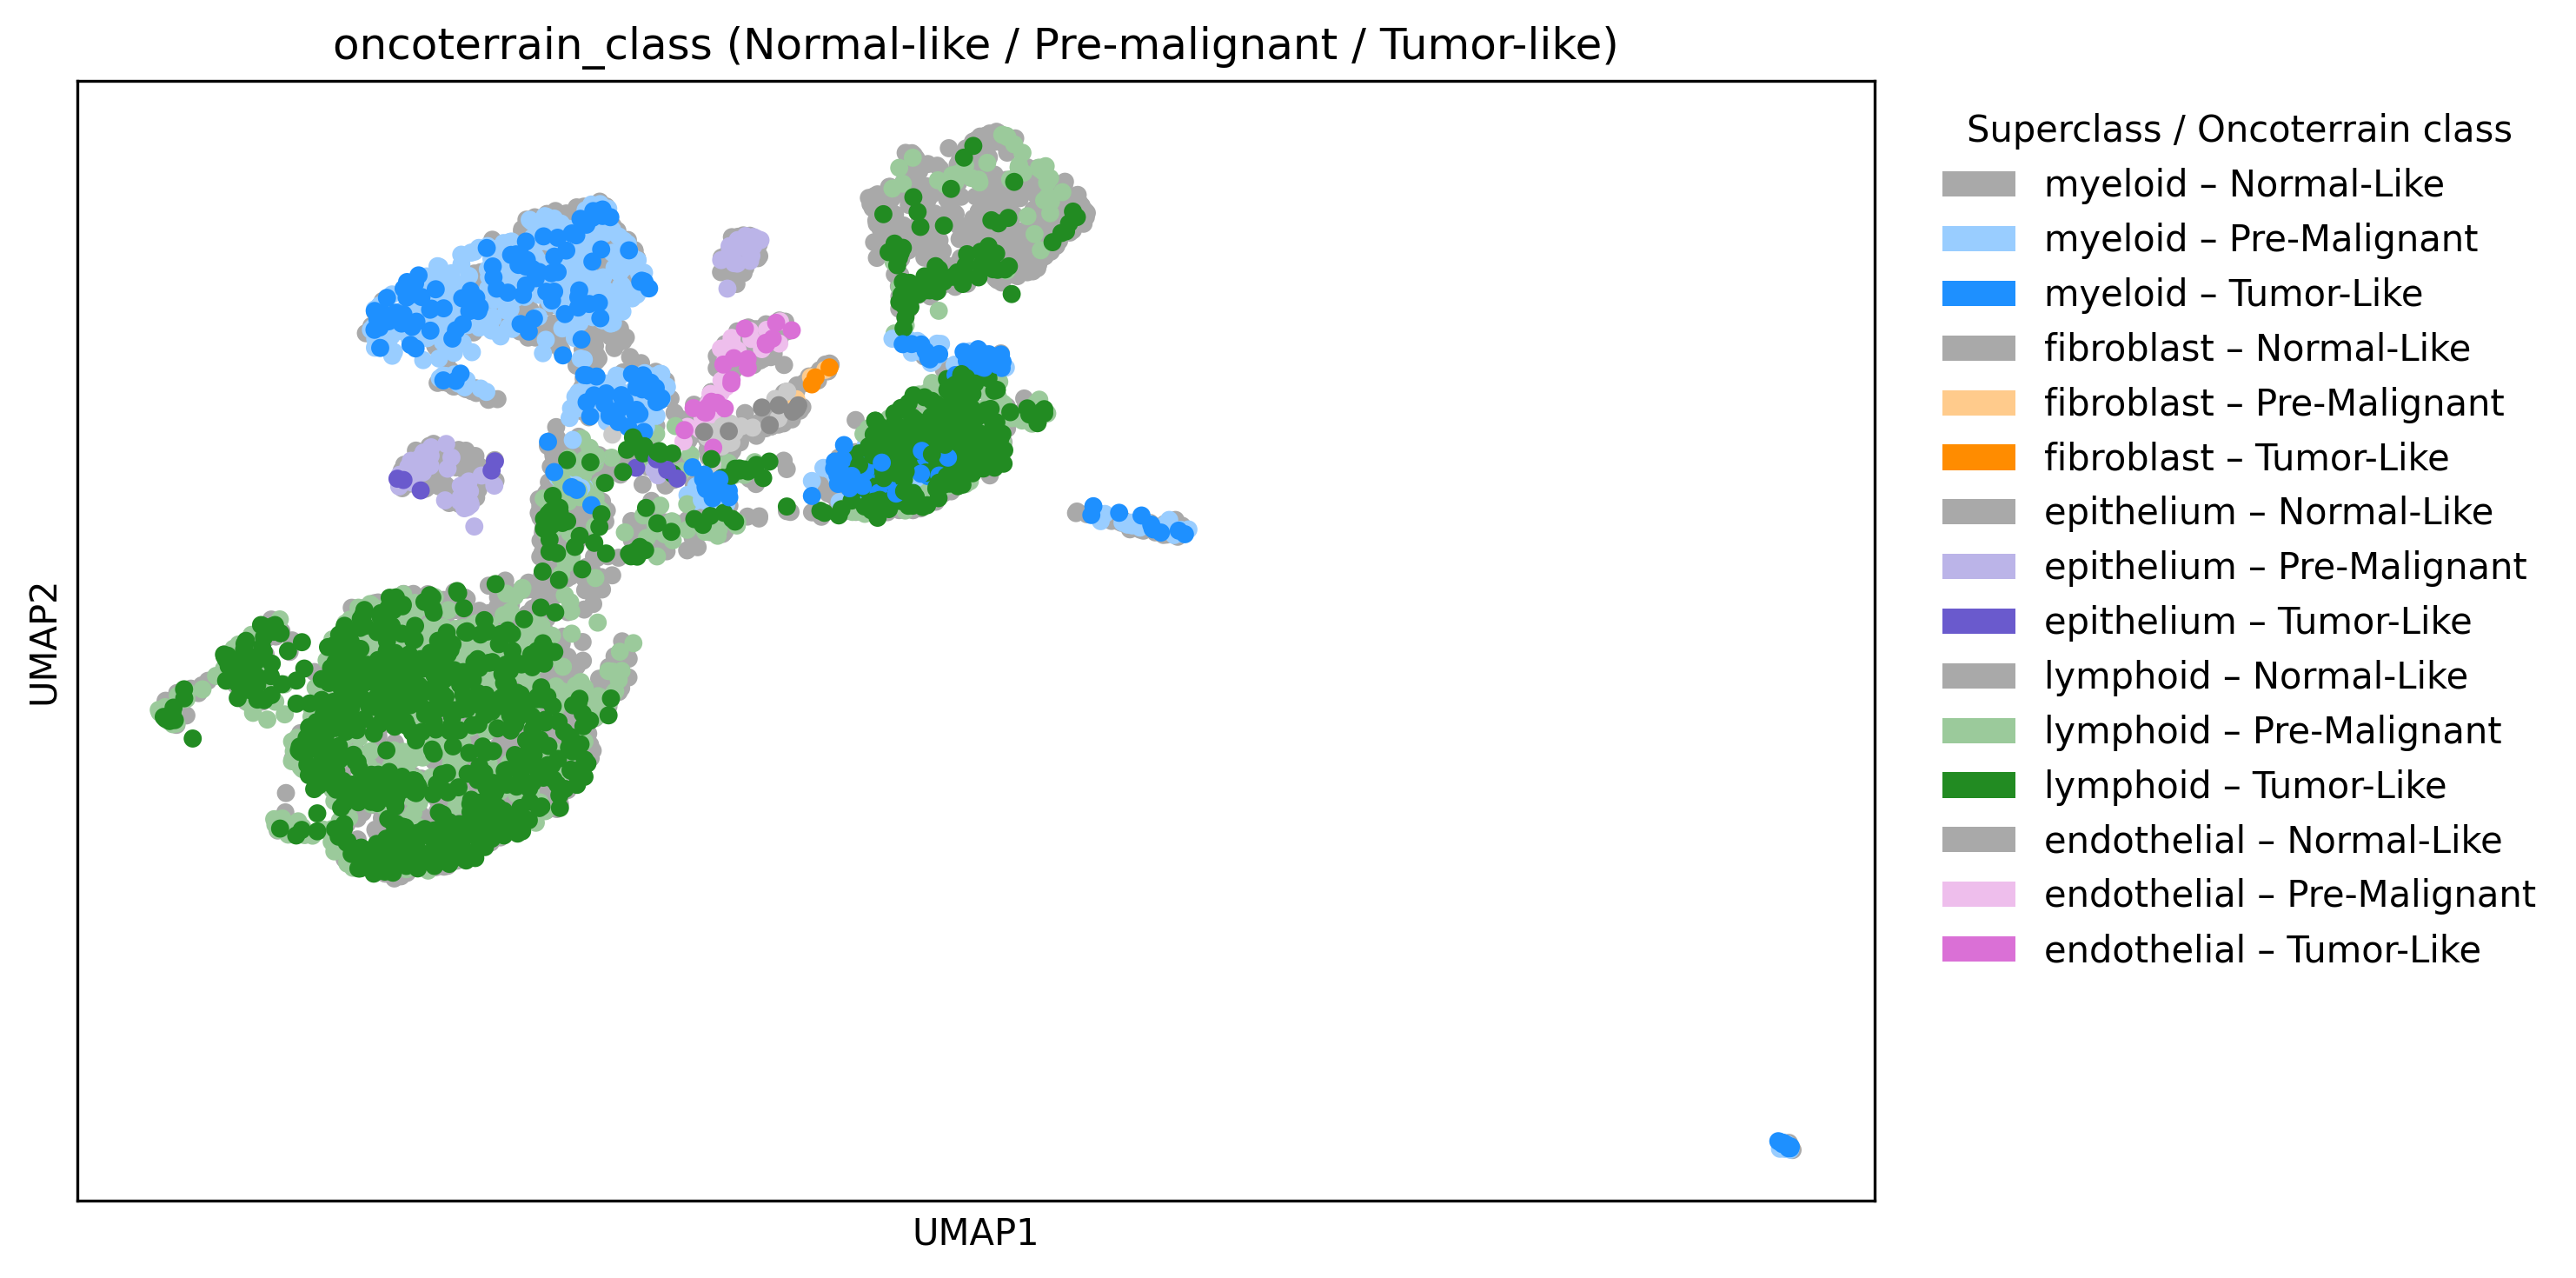

In [26]:
EPITHELIAL_CATS = [
    'AT2', 'AT1', 'Suprabasal', 'Basal resting',
    'Multiciliated (non-nasal)', 'Goblet (nasal)',
    'Club (nasal)', 'Ciliated (nasal)',
    'Club (non-nasal)', 'Multiciliated (nasal)',
    'Goblet (bronchial)', 'Transitional Club AT2',
    'AT2 proliferating', 'Goblet (subsegmental)'
]

FIBRO_CATS = [
    "Peribronchial fibroblasts", "Adventitial fibroblasts", "Alveolar fibroblasts",
    "Subpleural fibroblasts", "Myofibroblasts", "Fibromyocytes"
]

MYELOID_CATS = [
    'Alveolar macrophages', 'Alveolar Mφ MT-positive', 'Alveolar Mφ proliferating',
    'Interstitial Mφ perivascular', 'Alveolar Mφ CCL3+', 'Monocyte derived Mφ',
    'Mast cells', 'Plasmacytoid DCs', 'DC2', 'Migratory DCs',
    'Classical Monocytes', 'Non classical monocytes'
]

LYMPHOID_CATS = [
    'CD8 T cells', 'CD4 T cells', 'T cells proliferating', 'NK cells',
    'B cells', 'Plasma cells'
]

ENDOTHELIAL_CATS = [
    "EC venous pulmonary",
    "EC arterial",
    "EC venous systemic",
    "EC general capillary",
    "EC aerocyte capillary",
    "Lymphatic EC mature",
    "Lymphatic EC differentiating",
    "Lymphatic EC proliferating",
]

def to_superclass(name):
    if name in MYELOID_CATS:     return 'myeloid'
    if name in FIBRO_CATS:       return 'fibroblast'
    if name in EPITHELIAL_CATS:  return 'epithelium'
    if name in LYMPHOID_CATS:    return 'lymphoid'
    if name in ENDOTHELIAL_CATS: return 'endothelial'
    return 'other'

superclass = example_h5ad_annotated.obs[CELLTYPE_KEY].astype(str).map(to_superclass).fillna('other')

GRAY0 = "#A9A9A9"
BASE = {
    'myeloid':     "#1E90FF",  # blue
    'fibroblast':  "#FF8C00",  # orange
    'epithelium':  "#6A5ACD",  # purple
    'lymphoid':    "#228B22",  # green
    'endothelial': "#DA70D6",  # orchid/pink
    'other':       "#8B8B8B",
}

def lighten(hex_color, factor=0.55):
    hex_color = hex_color.lstrip('#')
    r, g, b = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]
    r = int(r + (255 - r) * factor)
    g = int(g + (255 - g) * factor)
    b = int(b + (255 - b) * factor)
    return f'#{r:02X}{g:02X}{b:02X}'

PALETTES = {}
for sup, base in BASE.items():
    PALETTES[sup] = {
        0: GRAY0,
        1: lighten(base, factor=0.55),
        2: base
    }

stage_order = ["normal-like", "pre-malignant", "tumor-like"]
stage_to_code = {name: i for i, name in enumerate(stage_order)}
code_to_stage = {i: name.title() for i, name in enumerate(stage_order)}

raw_stage = example_h5ad_annotated.obs['oncoterrain_class'].astype(str)
norm_stage = raw_stage.str.strip().str.lower().str.replace('_', '-', regex=False)

unseen = sorted(set(norm_stage) - set(stage_to_code))
if unseen:
    print("unmapped oncoterrain_class values:", unseen)

classes = norm_stage.map(stage_to_code).fillna(0).astype(int).values 

supers = superclass.values
colors = []
for c, s in zip(classes, supers):
    pal = PALETTES.get(s, PALETTES['other'])
    colors.append(pal.get(int(c), GRAY0))
colors = np.array(colors, dtype=object)

if 'X_umap' not in example_h5ad_annotated.obsm:
    sc.pp.neighbors(example_h5ad_annotated)
    sc.tl.umap(example_h5ad_annotated)

X = example_h5ad_annotated.obsm['X_umap']
x, y = X[:, 0], X[:, 1]

order = np.argsort(classes)
x, y, colors_ord = x[order], y[order], colors[order]

plt.figure(figsize=(10, 5), dpi=300)
plt.scatter(x, y, s=25, c=colors_ord, linewidths=0)
plt.xticks([]); plt.yticks([])
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.title("oncoterrain_class (Normal-like / Pre-malignant / Tumor-like)")

handles, labels = [], []
for sup in ['myeloid', 'fibroblast', 'epithelium', 'lymphoid', 'endothelial']:
    for k in [0, 1, 2]:
        handles.append(mpatches.Patch(facecolor=PALETTES[sup][k], edgecolor='none'))
        labels.append(f"{sup} – {code_to_stage[k]}")

plt.legend(handles, labels, title="Superclass / Oncoterrain class",
           loc='upper left', bbox_to_anchor=(1.02, 1.0),
           frameon=False, ncol=1)
plt.tight_layout()
plt.show()

In [27]:
example_h5ad_annotated.obs['tumor_stage'] = example_h5ad_annotated.obs['oncoterrain_class'].mode()

In [28]:
obs_cols = pd.Index(example_h5ad_annotated.obs.columns.astype(str))
hallmark_cols = [c for c in obs_cols if c.upper().startswith("HALLMARK_") or c.upper() in oncoterrain_instance.conditions]

if 'project' not in obs_cols:
    for alt in ['sample', 'sample_id', 'patient', 'batch']:
        if alt in obs_cols:
            example_h5ad_annotated.obs = example_h5ad_annotated.obs.rename(columns={alt: 'project'})
            break

if 'tumor_stage' not in obs_cols:
    for alt in ['stage', 'pathological_stage', 'clinical_stage']:
        if alt in obs_cols:
            adata.obs = adata.obs.rename(columns={alt: 'tumor_stage'})
            break

need_cols = ['project', 'tumor_stage']
missing = [c for c in need_cols if c not in example_h5ad_annotated.obs.columns]
if missing:
    raise KeyError(f"Missing required columns in adata.obs: {missing}")

meta_data = example_h5ad_annotated.obs[need_cols + hallmark_cols].copy()

for c in hallmark_cols:
    meta_data[c] = pd.to_numeric(meta_data[c], errors='coerce')

[OncoTerrain] Processing sample_id: 'SMP-7969'
[OncoTerrain] Rendering circular heatmap for project == 'SMP-7969'


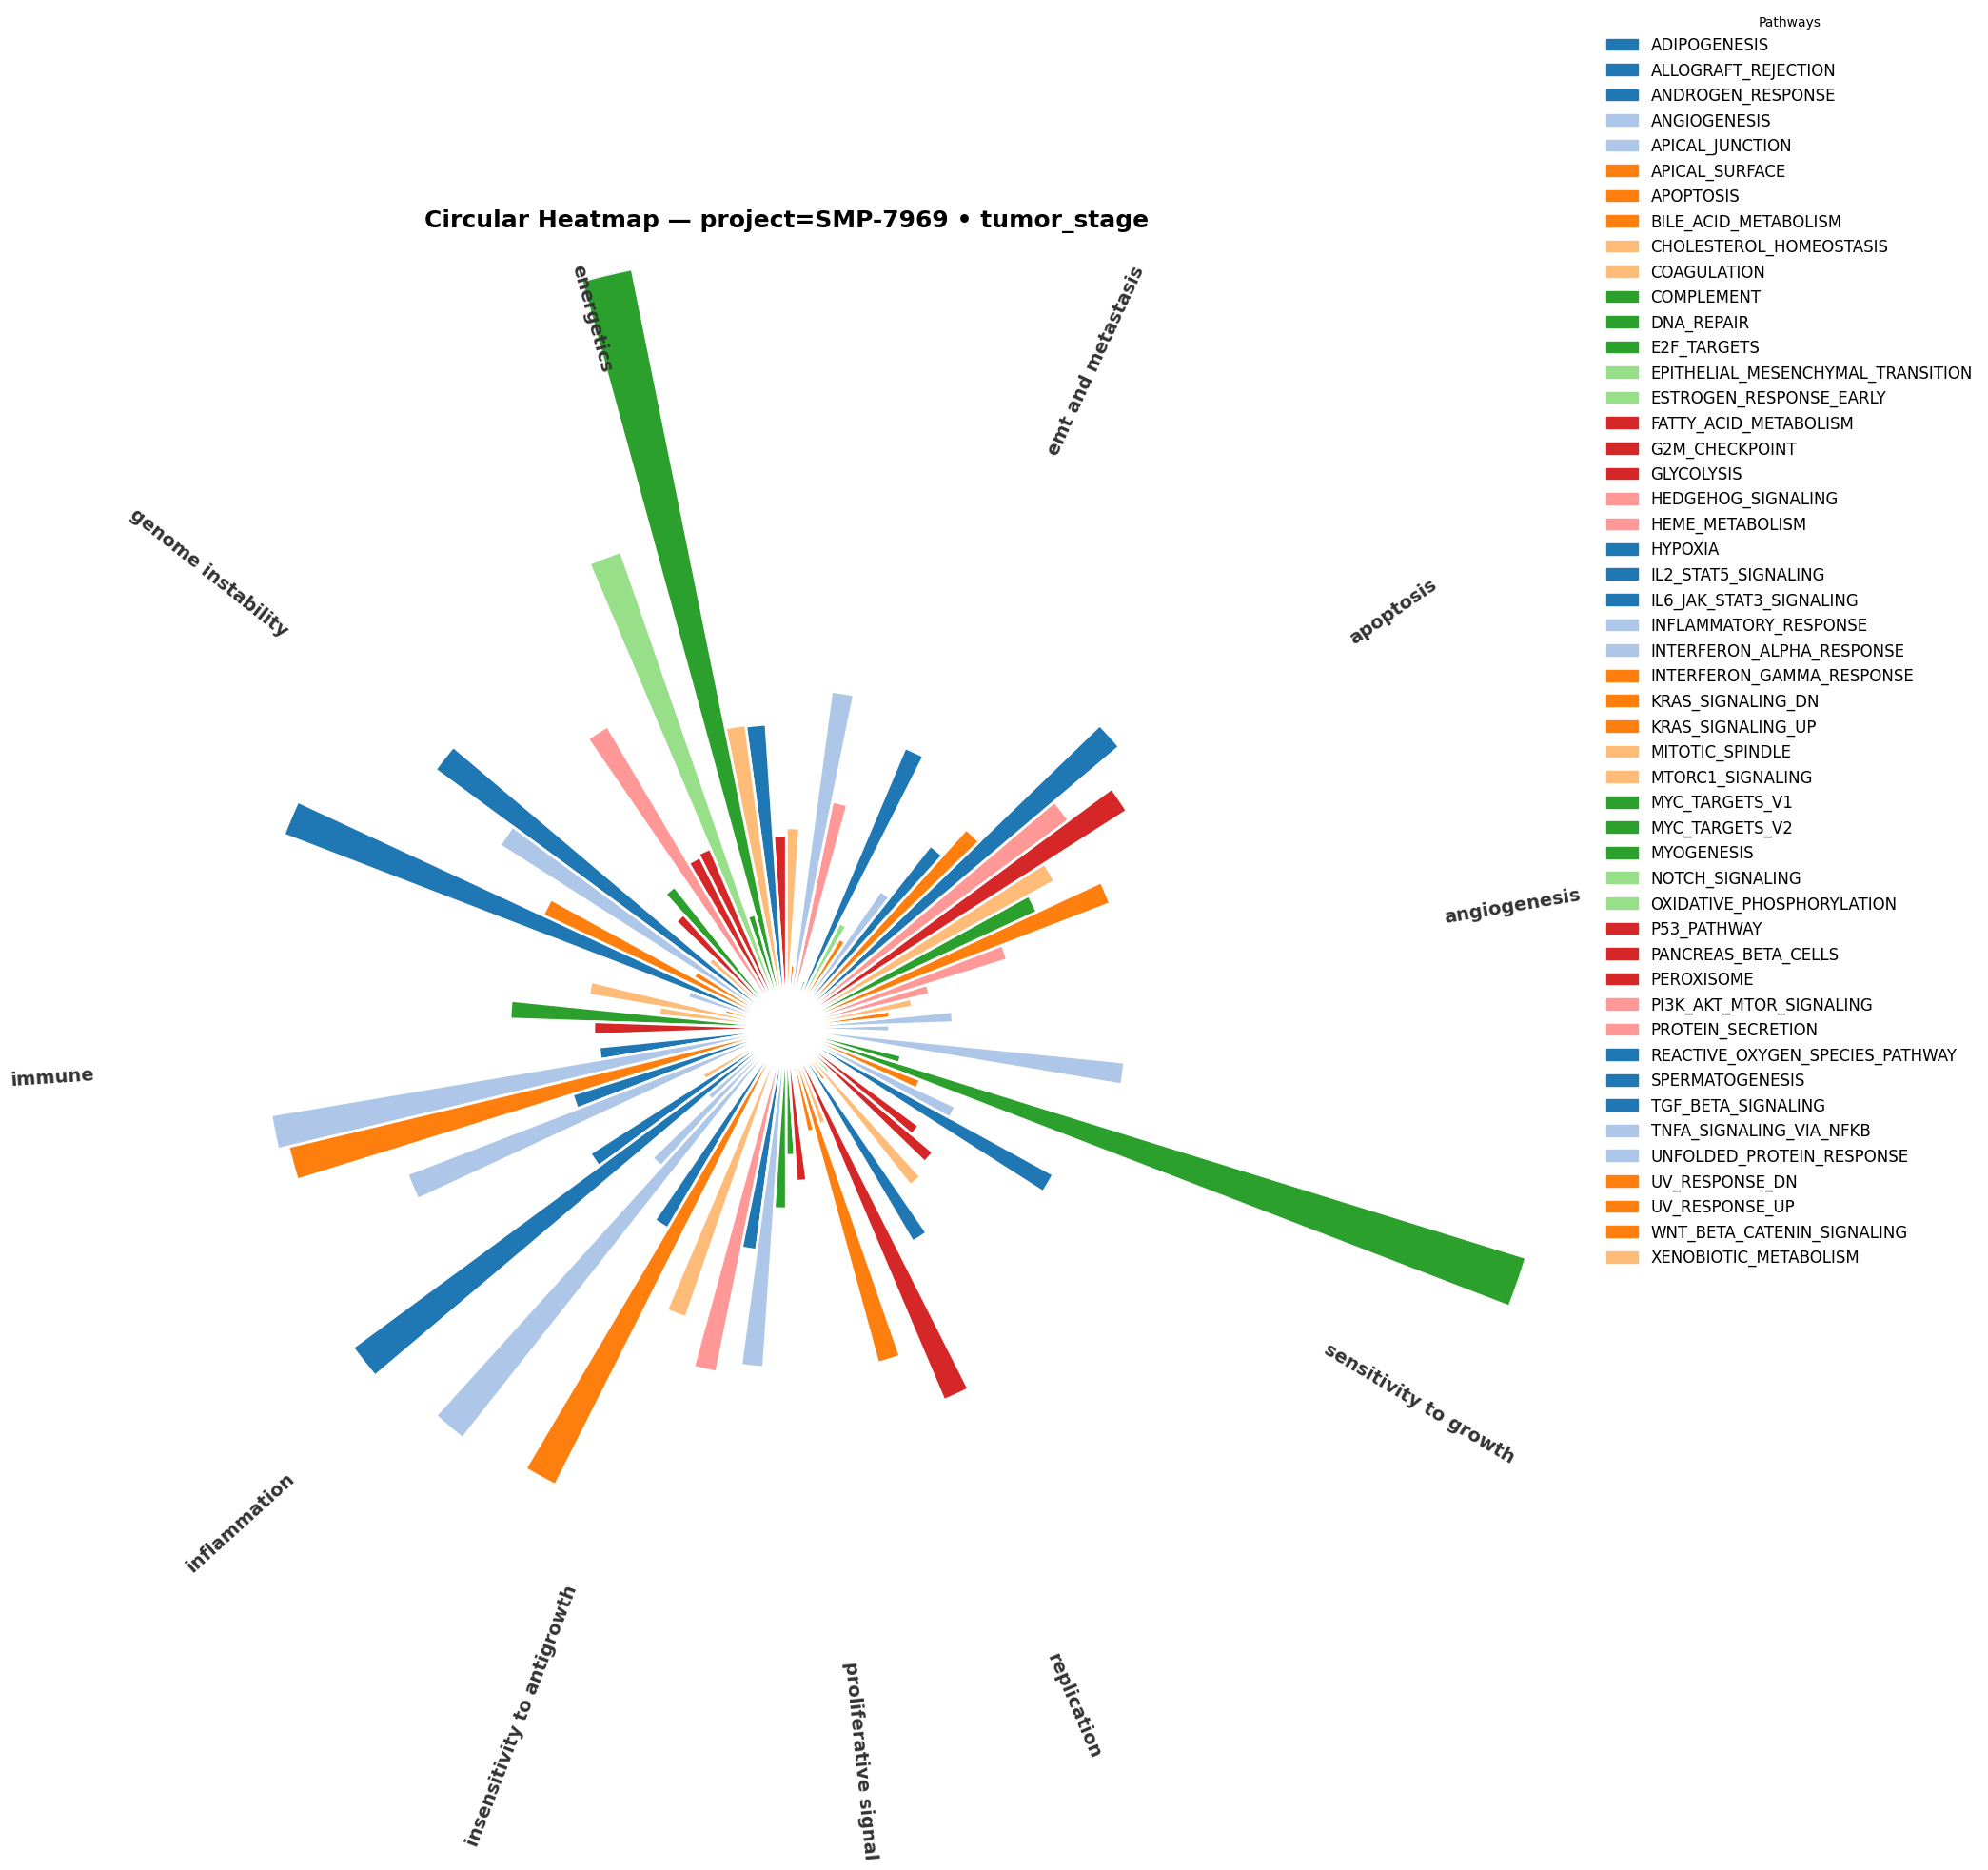

['vignette_output/circ_heatmaps/SMP-7969_circular_heatmap.png']

In [29]:
oncoterrain_instance.circular_heatmap(
    meta_data=meta_data,
    save_path="vignette_output/circ_heatmaps",
    stage_label='tumor_stage',
    groupby_column='project',    
    scale_range=(0, 100),
)